In [7]:
import os
import random
import shutil
import pandas as pd
import tqdm
# Paths for data organization
ORIGINAL_FOLDER = "/kaggle/input/code-data/train"
OUTPUT_FOLDER = "organized_dataset"
ALL_FILES_FOLDER = os.path.join(OUTPUT_FOLDER, "all_files")

# Ensure output folder exists
os.makedirs(ALL_FILES_FOLDER, exist_ok=True)

def list_cpp_files(folder_path):
    """List all cpp files in the given folder."""
    return [f for f in os.listdir(folder_path)]

def make_small_changes(code):
    """Introduce small modifications to simulate plagiarism."""
    lines = code.split("\n")
    if len(lines) > 2:
        random.shuffle(lines[:2])  # Shuffle first two lines
    return "\n".join(lines).replace("=", " = ")  # Add minor spacing variation

def create_dataset(folder_path, output_csv="plagiarism_dataset.csv"):
    """Generate dataset and save original & plagiarized code in a single new folder."""
    cpp_files = list_cpp_files(folder_path)
    random.shuffle(cpp_files)

    num_samples = len(cpp_files) // 2  # 50% sampling
    sampled_files = cpp_files[:num_samples]
    remaining_files = cpp_files[num_samples:]

    dataset = []
    plagiarized_versions = {}

    # Copy original files to new folder
    for filename in tqdm.tqdm(cpp_files):
        original_path = os.path.join(folder_path, filename)
        shutil.copy(original_path, os.path.join(ALL_FILES_FOLDER, filename))

    # Create plagiarized pairs (label 1) and save modified files
    for filename in sampled_files:
        original_path = os.path.join(folder_path, filename)
        with open(original_path, "r", encoding="utf-8") as f:
            original_code = f.read()

        modified_code = make_small_changes(original_code)

        plagiarized_filename = f"plagiarized_{filename}"
        plagiarized_path = os.path.join(ALL_FILES_FOLDER, plagiarized_filename)

        # Save modified file in the same folder
        with open(plagiarized_path, "w", encoding="utf-8") as f:
            f.write(modified_code)

        plagiarized_versions[plagiarized_filename] = modified_code

        dataset.append((filename, plagiarized_filename, 1))

    # Create non-plagiarized pairs (label 0)
    for filename in remaining_files:
        random_original = random.choice(list(plagiarized_versions.keys()))
        dataset.append((filename, random_original, 0))

    # Save dataset as CSV
    df = pd.DataFrame(dataset, columns=["code1", "code2", "label"])
    dataset_csv_path = os.path.join(OUTPUT_FOLDER, output_csv)
    df.to_csv(dataset_csv_path, index=False)

    print(f"Dataset saved to {dataset_csv_path}")
    print(f"All files (original & plagiarized) saved in: {ALL_FILES_FOLDER}")

# Example usage
create_dataset(ORIGINAL_FOLDER)


100%|██████████| 50000/50000 [02:15<00:00, 368.38it/s]


Dataset saved to organized_dataset/plagiarism_dataset.csv
All files (original & plagiarized) saved in: organized_dataset/all_files


In [8]:
import wandb

In [9]:
!wandb login eb394853d63497beca587e00e60a266a96801c61

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [14]:
import os
import torch
import pandas as pd
import json
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Load dataset CSV
df = pd.read_csv("/kaggle/working/organized_dataset/plagiarism_dataset.csv")

# Use only a subset 
df = df.sample(n=1000, random_state=42)  

# Folder where Python code files are stored
CODE_FOLDER = "/kaggle/working/organized_dataset/all_files"

def read_file_content(filename):
    """Reads the content of a Python file safely."""
    file_path = f"{CODE_FOLDER}/{filename}"
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            return f.read()
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        return ""

# Convert dataset into JSON format with actual code content
dataset_json = [
    {"text": f"Code 1:\n{read_file_content(row['code1'])}\n\nCode 2:\n{read_file_content(row['code2'])}",
     "label": row["label"]}
    for _, row in df.iterrows()
]

# Save dataset as JSON for reference
with open("plagiarism_dataset.json", "w") as f:
    json.dump(dataset_json, f, indent=4)

# Load CodeGPT tokenizer
MODEL_NAME = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class CodePlagiarismDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.texts = [data["text"] for data in dataset]
        self.labels = [data["label"] for data in dataset]
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Split dataset (80% train, 20% validation)
train_size = int(0.8 * len(dataset_json))
train_dataset = CodePlagiarismDataset(dataset_json[:train_size], tokenizer)
val_dataset = CodePlagiarismDataset(dataset_json[train_size:], tokenizer)

# Load pre-trained CodeGPT model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Define training arguments optimized for Google Colab
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    fp16=True,
)

# Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# Fine-tune the model
train_result = trainer.train()

# Save the fine-tuned model
model.save_pretrained("codegpt-plagiarism-detector")
tokenizer.save_pretrained("codegpt-plagiarism-detector")

print("Fine-tuning complete. Model saved to 'codegpt-plagiarism-detector'.")

# Extract training history
train_loss = train_result.metrics["train_loss"]

# Retrieve logs
logs = trainer.state.log_history
train_losses = [entry["loss"] for entry in logs if "loss" in entry]
val_losses = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-14-a643df89be0c>:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.670500,0.714817
2,0.700000,0.694863
3,0.685600,0.694863
4,0.699700,0.693367
5,0.692700,0.692708
6,0.686800,0.694561
7,0.693600,0.693313
8,0.714700,0.692876
9,0.693800,0.692686
10,0.691100,0.693008


Fine-tuning complete. Model saved to 'codegpt-plagiarism-detector'.


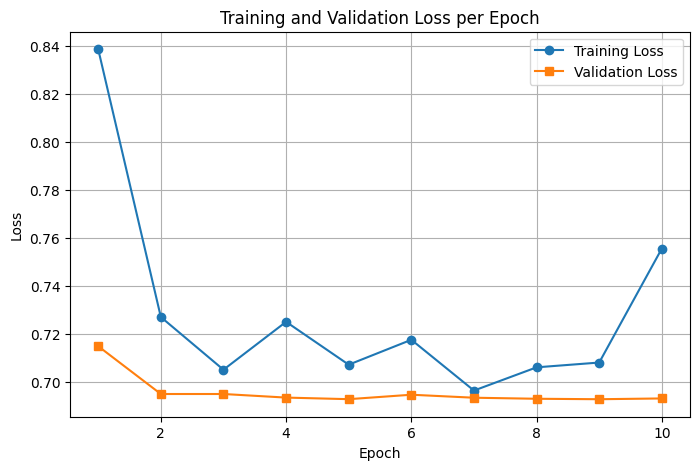

In [15]:
# Extract training history
logs = trainer.state.log_history

# Collect training losses at epoch level
train_losses = [entry["loss"] for entry in logs if "loss" in entry]
val_losses = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]

# Ensure same number of epochs for training and validation loss
num_epochs = min(len(train_losses), len(val_losses))
train_losses = train_losses[:num_epochs]
val_losses = val_losses[:num_epochs]

# Plot training and validation loss per epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid()
plt.show()


In [12]:
import os
import random
import shutil
import pandas as pd
import tqdm
# Paths
SOURCE_FOLDER = "/kaggle/input/code-data/test"  # Folder with original Python files
TARGET_FOLDER = "/kaggle/working/plagiarism_dataset"  # New folder for dataset storage
CSV_FILE = os.path.join(TARGET_FOLDER, "plagiarism_test_dataset.csv")

# Ensure target folder exists
os.makedirs(TARGET_FOLDER, exist_ok=True)

def list_python_files(folder_path):
    """List all Python files in the given folder."""
    return [f for f in os.listdir(folder_path)]

def make_small_changes(code):
    """Introduce small modifications to simulate plagiarism."""
    lines = code.split("\n")
    if len(lines) > 2:
        random.shuffle(lines[:2])  # Shuffle first two lines
    code = "\n".join(lines)
    return code.replace("=", " = ")  # Add minor spacing variation

def create_dataset():
    """Generate a dataset with original and plagiarized files, saving them in the new folder."""
    python_files = list_python_files(SOURCE_FOLDER)
    random.shuffle(python_files)

    num_samples = len(python_files) // 2  # 50% sampling
    sampled_files = python_files[:num_samples]
    remaining_files = python_files[num_samples:]

    dataset = []
    plagiarized_versions = {}

    # Copy original files to target folder and create plagiarized versions
    for filename in tqdm.tqdm(sampled_files):
        original_path = os.path.join(SOURCE_FOLDER, filename)
        target_original_path = os.path.join(TARGET_FOLDER, filename)

        # Copy original file to new folder
        shutil.copy(original_path, target_original_path)

        with open(original_path, "r", encoding="utf-8") as f:
            original_code = f.read()

        modified_code = make_small_changes(original_code)

        plagiarized_filename = f"plagiarized_{filename}"
        plagiarized_path = os.path.join(TARGET_FOLDER, plagiarized_filename)

        # Save modified file in the new folder
        with open(plagiarized_path, "w", encoding="utf-8") as f:
            f.write(modified_code)

        plagiarized_versions[plagiarized_filename] = modified_code

        dataset.append((filename, plagiarized_filename, 1))  # Label 1 (Plagiarized)

    # Create non-plagiarized pairs (label 0)
    for filename in remaining_files:
        random_original = random.choice(list(plagiarized_versions.keys()))
        dataset.append((filename, random_original, 0))

        # Also copy non-plagiarized files to target folder
        original_path = os.path.join(SOURCE_FOLDER, filename)
        target_original_path = os.path.join(TARGET_FOLDER, filename)
        shutil.copy(original_path, target_original_path)

    # Save dataset as CSV
    df = pd.DataFrame(dataset, columns=["code1", "code2", "label"])
    df.to_csv(CSV_FILE, index=False)

    print(f"Dataset saved to {CSV_FILE}")
    print(f"All files (original & plagiarized) saved in {TARGET_FOLDER}")

# Run dataset creation
create_dataset()


100%|██████████| 12500/12500 [00:50<00:00, 246.03it/s]


Dataset saved to /kaggle/working/plagiarism_dataset/plagiarism_test_dataset.csv
All files (original & plagiarized) saved in /kaggle/working/plagiarism_dataset


In [16]:
import os
import torch
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define paths
MODEL_PATH = "/kaggle/working/codegpt-plagiarism-detector"  # Path to fine-tuned model
TEST_CSV = "/kaggle/working/plagiarism_dataset/plagiarism_test_dataset.csv"  # Test dataset
CODE_FOLDER = "/kaggle/working/plagiarism_dataset"  # Folder containing Python files

# Load fine-tuned model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model.eval()  # Set model to evaluation mode


def read_file_content(filename):
    """Reads the content of a Python file safely."""
    file_path = f"{CODE_FOLDER}/{filename}"  # Directly concatenate strings
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            return f.read()
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        return ""

def predict_plagiarism(code1, code2):
    """Predicts plagiarism between two pieces of code."""
    text = f"Code 1:\n{code1}\n\nCode 2:\n{code2}"
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)

    prediction = torch.argmax(outputs.logits, dim=1).item()
    return prediction  # 1 = Plagiarized, 0 = Not Plagiarized

# Load test dataset
df = pd.read_csv(TEST_CSV)
# Select a random subset for testing
df = df.sample(n=200, random_state=42)  # Select only SAMPLE_SIZE samples
df["predicted_label"] = df.apply(
    lambda row: predict_plagiarism(read_file_content(row["code1"]), read_file_content(row["code2"])), axis=1
)

# Calculate evaluation metrics
y_true = df["label"].tolist()  # Ground truth
y_pred = df["predicted_label"].tolist()  # Model predictions

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Save results
df.to_csv("plagiarism_test_predictions.csv", index=False)
print("Predictions saved to 'plagiarism_predictions.csv'.")


Accuracy: 0.5250
Precision: 0.5250
Recall: 1.0000
F1 Score: 0.6885
Predictions saved to 'plagiarism_predictions.csv'.
